# Lesson 1: Router Engine

Welcome to Lesson 1.

To access the `requirements.txt` file, the data/pdf file required for this lesson and the `helper` and `utils` modules, please go to the `File` menu and select`Open...`.

I hope you enjoy this course!

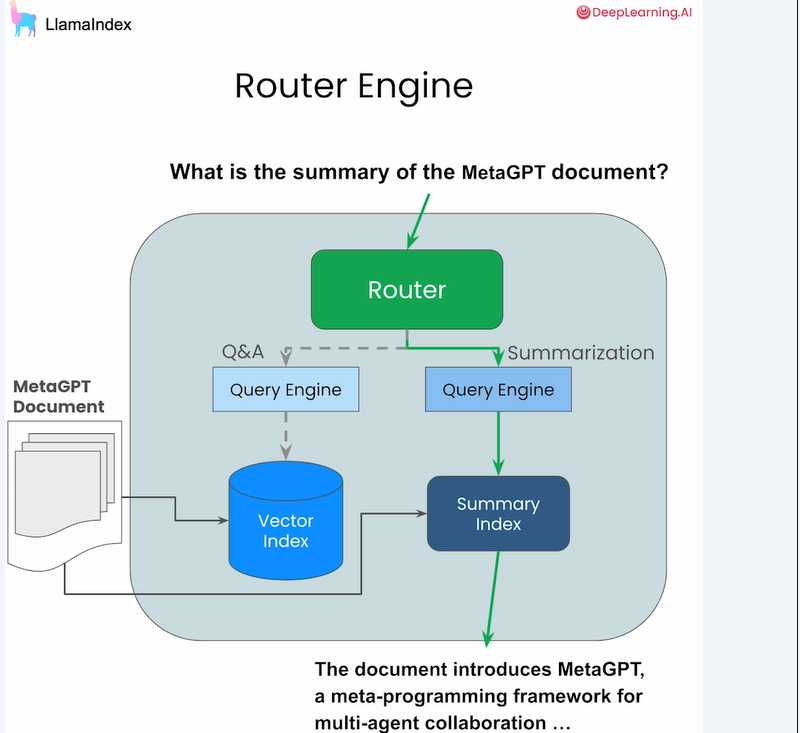

## Setup

In [29]:
import nest_asyncio

nest_asyncio.apply()

## Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [2]:
!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O /home/ashok/Documents/csvrag/metagpt.pdf

--2025-03-20 06:26:47--  https://openreview.net/pdf?id=VtmBAGCN7o
Resolving openreview.net (openreview.net)... 35.184.86.251
connected. to openreview.net (openreview.net)|35.184.86.251|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 16911937 (16M) [application/pdf]
Saving to: ‘/home/ashok/Documents/metagpt.pdf’

/home/ashok/Documen 100%[===================>]  16.13M  4.04MB/s    in 5.7s    

2025-03-20 06:26:54 (2.85 MB/s) - ‘/home/ashok/Documents/metagpt.pdf’ saved [16911937/16911937]



In [25]:
%reset

# Ollama related
# https://docs.llamaindex.ai/en/stable/examples/embeddings/ollama_embedding/
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["/home/ashok/Documents/csvrag/metagpt.pdf"]).load_data()

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Define LLM and Embedding model

In [30]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [32]:
len(nodes)

34

In [33]:
from llama_index.core import Settings

Settings.llm = Settings.llm = Ollama(
                                     model="llama3.2:latest",
                                     request_timeout=120.0,
                                     temperature = 0.4,
                                     mirostat = 0)

Settings.embed_model = OllamaEmbedding(
                                        model_name="nomic-embed-text",      # Using foundational model may be overkill
                                        base_url="http://localhost:11434",
                                       )

## Define Summary Index and Vector Index over the Same Data

In [34]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(
                                 nodes,
                                 show_progres = True
                               )

## Define Query Engines and Set Metadata

In [35]:
summary_query_engine = summary_index.as_query_engine(
                                                     response_mode="tree_summarize",
                                                     use_async=True,  # Optional but gives faster response
                                                    )

vector_query_engine = vector_index.as_query_engine(show_progress = True)

In [36]:
from llama_index.core.tools import QueryEngineTool


summary_tool = QueryEngineTool.from_defaults(
                                             query_engine=summary_query_engine,
                                             description=(
                                                          "Useful for summarization questions related to MetaGPT"
                                                          ),
                                              )

vector_tool = QueryEngineTool.from_defaults(
                                             query_engine=vector_query_engine,
                                             description=(
                                                           "Useful for retrieving specific context from the MetaGPT paper."
                                                         ),
                                            )

## Define Router Query Engine
Here is our router

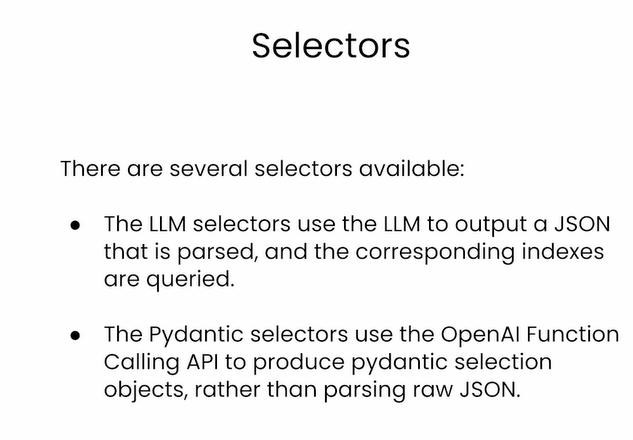

The first selector returns a JSON object, the second one retuns a string and not raw json.

In [37]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

# Router takes two arguments:
#                              Which router
#                              NAmes of Query engine tools

query_engine = RouterQueryEngine(
                                 selector=LLMSingleSelector.from_defaults(),
                                 query_engine_tools=[
                                                        summary_tool,    # 0
                                                        vector_tool,     # 1
                                                    ],
                                 verbose=True
                               )

In [38]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 1: It allows users to retrieve specific context from the MetaGPT paper, which could be useful for answering questions about summaries..
The document appears to be a technical specification or guide for developing an application, likely related to a graphical user interface. It outlines the required packages, APIs, and components needed for the project. The document also includes information on the program call flow and task assignments, suggesting that it is part of a larger software development process. Overall, the document seems to provide detailed instructions and guidelines for building and maintaining the application.


In [17]:
print(len(response.source_nodes))

2


In [18]:
response = query_engine.query(
                              "How do agents share information with other agents?"
                             )
print(str(response))

Selecting query engine 1: The MetaGPT paper discusses the architecture and mechanisms of agents, including how they share information with other agents..
Agents use a shared message pool to publish structured messages. They can also subscribe to relevant messages based on their profiles.


## Let's put everything together

In [27]:
#from utils import get_router_query_engine

from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.embeddings.ollama import OllamaEmbedding
from llama_index.llms.ollama import Ollama
from llama_index.core import SummaryIndex, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector




def get_router_query_engine(file_path: str, llm = None, embed_model = None):
    """Get router query engine."""
    llm = Settings.llm = Ollama(
                        model="llama3.2:latest",
                        request_timeout=120.0,
                        temperature = 0.0,
                        mirostat = 0)

    embed_model = OllamaEmbedding( 
                                    model_name="nomic-embed-text",      # Using foundational model may be overkill
                                    base_url="http://localhost:11434",
                                       )
        
    # load documents
    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)
    
    summary_index = SummaryIndex(nodes)
    vector_index = VectorStoreIndex(nodes, embed_model=embed_model)
    
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize",
        use_async=True,  # Optional but gives faster response
        llm=llm
    )
    vector_query_engine = vector_index.as_query_engine(llm=llm)
    
    summary_tool = QueryEngineTool.from_defaults(
        query_engine=summary_query_engine,
        description=(
            "Useful for summarization questions related to MetaGPT"
        ),
    )
    
    vector_tool = QueryEngineTool.from_defaults(
        query_engine=vector_query_engine,
        description=(
            "Useful for retrieving specific context from the MetaGPT paper."
        ),
    )
    
    query_engine = RouterQueryEngine(
        selector=LLMSingleSelector.from_defaults(),
        query_engine_tools=[
            summary_tool,
            vector_tool,
        ],
        verbose=True
    )
    return query_engine

query_engine = get_router_query_engine("metagpt.pdf")  




In [28]:
response = query_engine.query("Tell me about the ablation study results?")
print(str(response))

Selecting query engine 1: The ablation study results are likely to be discussed in the context of the MetaGPT paper, making option (2) the most relevant choice..
The MetaGPT model outperforms all preceding approaches in both HumanEval and MBPP benchmarks. When collaborating with GPT-4, it significantly improves Pass @k in the HumanEval benchmark. The collaboration achieves 85.9% and 87.7%.
